In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from tqdm import tqdm
import json
import os
import random
import math
import pickle
#import umap
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, confusion_matrix
from collections import deque

# import stellargraph as sg
# from stellargraph.mapper import FullBatchNodeGenerator
# from stellargraph.layer import GCN
import networkx as nx
import warnings
import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, constraints, regularizers
from tensorflow.keras.layers import Input, Layer, Lambda, Dropout, Reshape, Dense, Embedding,LeakyReLU, Maximum
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers, optimizers, losses, metrics, Model
import matplotlib.pyplot as plt
import seaborn as sns
# from stellargraph import StellarGraph
# from stellargraph.layer.gcn import GatherIndices
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

%matplotlib inline

In [3]:
dataFrame = pd.read_csv("/content/drive/MyDrive/GCN Classification/citation_sentiment_corpus.txt", sep = "	", header = None)
dataFrame.columns = ["Source_PaperID", "Target_PaperID", "Sentiment", "Citation_text"]
dataFrame.Sentiment = dataFrame.Sentiment.replace({"o": 1,"p": 2,"n": 0})

In [4]:
Source = dataFrame['Source_PaperID']
Target = dataFrame['Target_PaperID']
Sentiment = dataFrame['Sentiment']
G = nx.DiGraph(directed=True)
edges = pd.DataFrame(
    {
        "source": Source,
        "target": Target,
        "weight": Sentiment
    }
)
G = nx.from_pandas_edgelist(edges, edge_attr=True,create_using=nx.DiGraph())

In [5]:
leaderboard = {}
for x in G.nodes:
 leaderboard[x] = len(G[x])
s = pd.Series(leaderboard, name='Citations')
citation_counts = s.to_frame().sort_values('Citations', ascending=False)
citation_counts.value_counts()

Citations
1            1785
2             703
3             295
4             121
0              77
5              59
6              19
7               7
8               3
dtype: int64

In [6]:
citation_counts = citation_counts.reset_index(level=0)
citation_counts.columns = ['Node', 'Citations']
citation_counts.head()

,Node,Citations
0,W08-0306,8
1,N09-1058,8
2,D07-1070,8
3,N09-1049,7
4,P08-1068,7


In [7]:
zero_list = []
for i,j in zip(citation_counts['Node'], citation_counts['Citations']):
    if(j == 0):
      
        zero_list.append(i)
G.remove_nodes_from(zero_list)

In [8]:
print("Number of Nodes: ",G.number_of_nodes())
print("Number of Edges: ",G.number_of_edges())

Number of Nodes:  2992
Number of Edges:  1589


In [9]:
import os
all_data = []

for root,dirs,files in os.walk('.'):
    for file in files:
        if 'node2vec_embeddings.txt' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
all_data

#parse the data
nodes = []
node2vec_cc = []

for i,data in enumerate(all_data):
    elements = data.split(' ')
    node2vec_cc.append(elements[1:])
    nodes.append(elements[0])

In [10]:
node2vec_cc.pop(0)
nodes.pop(0)

'2992'

In [11]:
! pip install tensorflow_text
! pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 22.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import tensorflow_hub as hub
import tensorflow_text as text

In [13]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2"
bert_preprocess_model = hub.KerasLayer(preprocess_url)

In [14]:
df = dataFrame

In [15]:
citation_text = []
for i in nodes:
    for j,k in zip(df['Source_PaperID'],df['Citation_text']):
        if(i==j):
            citation_text.append(k)
            break

In [16]:
text_test = citation_text
text_preprocessed = bert_preprocess_model(text_test)


In [17]:
bert_model = hub.KerasLayer(encoder_url)
bert_results = bert_model(text_preprocessed)
bert_results.keys()


dict_keys(['default', 'pooled_output', 'encoder_outputs', 'sequence_output'])

In [18]:
pooled_output = bert_results['pooled_output']
print("Shape of pooled_output:", pooled_output.shape)
print("Values of pooled_output:", pooled_output.numpy())

Shape of pooled_output: (2992, 128)
Values of pooled_output: [[-0.14681141  0.8611589  -0.06422304 ...  0.923064    0.31110084
   0.94732934]
 [ 0.01465445  0.96255964  0.45316988 ...  0.949046    0.9329498
   0.9408248 ]
 [ 0.05313522  0.61497766  0.41243902 ...  0.95162016  0.8346753
   0.9756313 ]
 ...
 [-0.06295735  0.9119968  -0.23528008 ...  0.9131104   0.29114988
   0.97878695]
 [-0.03002188  0.85984194 -0.19387652 ...  0.9201683   0.4242918
   0.974417  ]
 [-0.01677701  0.92273664  0.74263084 ...  0.9372823   0.8992512
   0.90070945]]


In [19]:
final_embeddings = pooled_output
print(final_embeddings.shape)

(2992, 128)


In [20]:
column_names =[f"term_{idx}" for idx in range(128)]
final_embeddings = pd.DataFrame(final_embeddings, columns = column_names)

In [21]:
final_embeddings.head()

,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,...,term_118,term_119,term_120,term_121,term_122,term_123,term_124,term_125,term_126,term_127
0,-0.146811,0.861159,-0.064223,-0.706076,0.475757,0.066746,0.518006,0.737401,0.114674,0.931819,...,-0.094197,0.217231,-0.656255,-0.893191,0.993216,-0.062743,0.999364,0.923064,0.311101,0.947329
1,0.014654,0.962560,0.453170,-0.618179,0.908158,-0.048274,-0.078413,0.839713,-0.007041,0.886331,...,-0.100596,0.882265,-0.149974,-0.979522,0.990790,-0.036347,0.999877,0.949046,0.932950,0.940825
2,0.053135,0.614978,0.412439,0.579741,0.889144,-0.013936,-0.033425,0.913028,0.006780,0.943780,...,-0.106650,0.341189,-0.884892,-0.991994,0.941894,-0.016466,0.991007,0.951620,0.834675,0.975631
3,-0.002764,0.583788,0.073414,0.532142,0.947157,0.045536,0.358578,0.904988,0.013939,0.910273,...,-0.088946,0.828692,-0.571684,-0.994890,0.960661,-0.070185,0.996823,0.949918,0.361986,0.991978
4,-0.016674,0.919034,-0.095527,-0.847570,0.968573,0.002283,-0.688633,0.569275,0.036615,0.842072,...,-0.065311,0.803861,-0.373202,-0.989701,0.976374,-0.026972,0.999701,0.917807,0.954203,0.917098


In [22]:
final_embeddings["Node_id"] = nodes

In [23]:
df = dataFrame
labels = []
for i in nodes:
    for j,k in zip(df['Source_PaperID'],df['Sentiment']):
        if(i==j):
            labels.append(k)
            break

In [24]:
dataset = final_embeddings

In [25]:
dataset["label"] = labels
dataset.label.value_counts()

1    2622
2     283
0      87
Name: label, dtype: int64

In [26]:
dataset.head()

,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,...,term_120,term_121,term_122,term_123,term_124,term_125,term_126,term_127,Node_id,label
0,-0.146811,0.861159,-0.064223,-0.706076,0.475757,0.066746,0.518006,0.737401,0.114674,0.931819,...,-0.656255,-0.893191,0.993216,-0.062743,0.999364,0.923064,0.311101,0.947329,J97-3002,1
1,0.014654,0.962560,0.453170,-0.618179,0.908158,-0.048274,-0.078413,0.839713,-0.007041,0.886331,...,-0.149974,-0.979522,0.990790,-0.036347,0.999877,0.949046,0.932950,0.940825,N03-1017,1
2,0.053135,0.614978,0.412439,0.579741,0.889144,-0.013936,-0.033425,0.913028,0.006780,0.943780,...,-0.884892,-0.991994,0.941894,-0.016466,0.991007,0.951620,0.834675,0.975631,W96-0213,1
3,-0.002764,0.583788,0.073414,0.532142,0.947157,0.045536,0.358578,0.904988,0.013939,0.910273,...,-0.571684,-0.994890,0.960661,-0.070185,0.996823,0.949918,0.361986,0.991978,W02-1011,1
4,-0.016674,0.919034,-0.095527,-0.847570,0.968573,0.002283,-0.688633,0.569275,0.036615,0.842072,...,-0.373202,-0.989701,0.976374,-0.026972,0.999701,0.917807,0.954203,0.917098,P04-1035,1


In [27]:
node2vec_cc = dataset

In [28]:
graph = nx.to_pandas_edgelist(G)
graph


,source,target,weight
0,W09-0604,N03-1003,1
1,A00-1031,W96-0213,1
2,A97-1004,W96-0213,1
3,C08-1026,P08-1085,2
4,N01-1023,W96-0213,1
...,...,...,...
1584,W07-1209,W96-0213,1
1585,W07-1516,W96-0213,2
1586,W07-2053,W96-0213,1
1587,W08-0611,W96-0213,1


In [32]:
node2vec_cc

,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,...,term_120,term_121,term_122,term_123,term_124,term_125,term_126,term_127,Node_id,label
0,-0.146811,0.861159,-0.064223,-0.706076,0.475757,0.066746,0.518006,0.737401,0.114674,0.931819,...,-0.656255,-0.893191,0.993216,-0.062743,0.999364,0.923064,0.311101,0.947329,959,1
1,0.014654,0.962560,0.453170,-0.618179,0.908158,-0.048274,-0.078413,0.839713,-0.007041,0.886331,...,-0.149974,-0.979522,0.990790,-0.036347,0.999877,0.949046,0.932950,0.940825,992,1
2,0.053135,0.614978,0.412439,0.579741,0.889144,-0.013936,-0.033425,0.913028,0.006780,0.943780,...,-0.884892,-0.991994,0.941894,-0.016466,0.991007,0.951620,0.834675,0.975631,2887,1
3,-0.002764,0.583788,0.073414,0.532142,0.947157,0.045536,0.358578,0.904988,0.013939,0.910273,...,-0.571684,-0.994890,0.960661,-0.070185,0.996823,0.949918,0.361986,0.991978,2087,1
4,-0.016674,0.919034,-0.095527,-0.847570,0.968573,0.002283,-0.688633,0.569275,0.036615,0.842072,...,-0.373202,-0.989701,0.976374,-0.026972,0.999701,0.917807,0.954203,0.917098,1340,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,-0.018743,0.979233,-0.459713,-0.786456,0.901895,-0.041605,-0.002049,0.899776,0.031160,0.816297,...,-0.396568,-0.982140,0.991915,-0.085699,0.999905,0.933710,0.677862,0.981148,2298,1
2988,-0.008033,0.749812,0.254128,0.139298,0.829778,0.032444,0.420948,0.861712,0.116055,0.906824,...,-0.782793,-0.995381,0.970283,0.018546,0.982985,0.966177,0.797364,0.993248,449,2
2989,-0.062957,0.911997,-0.235280,-0.353653,0.771728,0.112082,0.142931,0.901406,0.099892,0.929686,...,-0.749153,-0.949720,0.985500,-0.041574,0.996479,0.913110,0.291150,0.978787,795,1
2990,-0.030022,0.859842,-0.193877,-0.361198,0.909212,0.043197,-0.442209,0.767495,0.104567,0.932727,...,0.125174,-0.988938,0.993493,-0.021910,0.999534,0.920168,0.424292,0.974417,1818,1


In [29]:
class_values = sorted(node2vec_cc["label"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(node2vec_cc["Node_id"].unique()))}

node2vec_cc["Node_id"] = node2vec_cc["Node_id"].apply(lambda name: paper_idx[name])
graph["source"] = graph["source"].apply(lambda name: paper_idx[name])
graph["target"] = graph["target"].apply(lambda name: paper_idx[name])
node2vec_cc["label"] = node2vec_cc["label"].apply(lambda value: class_idx[value])

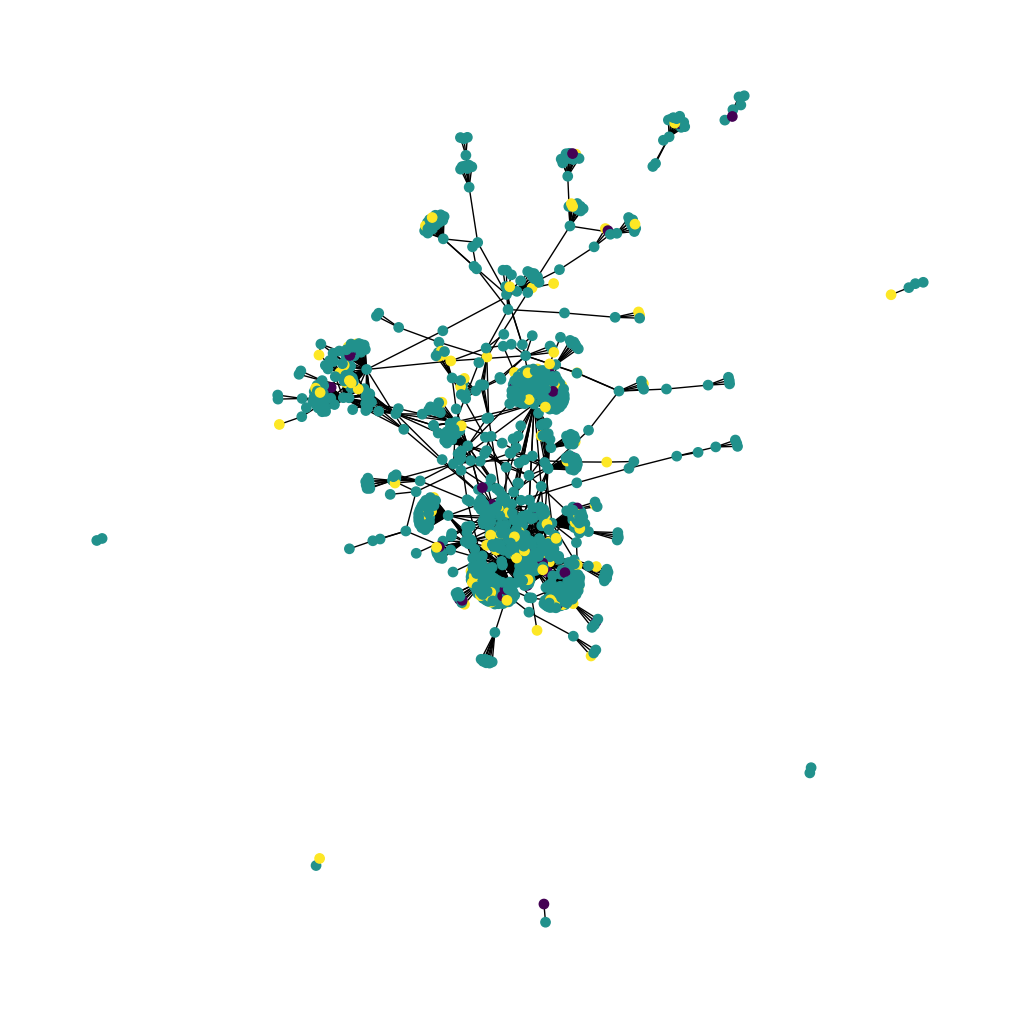

In [30]:
plt.figure(figsize=(10, 10))
colors = node2vec_cc["label"].tolist()
cora_graph = nx.from_pandas_edgelist(graph.sample(n=1500))
subjects = list(node2vec_cc[node2vec_cc["Node_id"].isin(list(cora_graph.nodes))]["label"])
nx.draw_spring(cora_graph, node_size=45, node_color=subjects)

In [31]:
train_data, test_data = [], []

for _, group_data in node2vec_cc.groupby("label"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1568, 130)
Test data shape: (1424, 130)


In [33]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [34]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [35]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [36]:
feature_names = set(node2vec_cc.columns) - {"Node_id", "label"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["label"]
y_test = test_data["label"]

<ipython-input-36-dc99dc6aeccb>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train = train_data[feature_names].to_numpy()
<ipython-input-36-dc99dc6aeccb>:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_test = test_data[feature_names].to_numpy()


In [37]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = graph[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].

# node2vec_cc[feature_names] = node2vec_cc[feature_names].apply(lambda x: pd.to_numeric(x, errors='coerce'))


# node_features = tf.cast(
#     node2vec_cc.sort_values("Node_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
# )

node_features = tf.cast(
    node2vec_cc.sort_values('Node_id')[column_names].apply(pd.to_numeric).to_numpy(), dtype=tf.dtypes.float32
)

# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 1589)
Nodes shape: (2992, 128)


In [38]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [39]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [40]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [41]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([5, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.11422084 -0.30147392 -0.08367432]
 [ 0.07685717 -0.32402998 -0.11042516]
 [ 0.06959486 -0.23933518 -0.02348104]], shape=(3, 3), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2992, 32)                5824      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (2992, 32)                2368      
                                                                 
 logits (Den

In [42]:
x_train = train_data.Node_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
6/6 [==============================] - 7s 202ms/step - loss: 1.1643 - acc: 0.5443 - val_loss: 0.6452 - val_acc: 0.8771
Epoch 2/300
6/6 [==============================] - 0s 72ms/step - loss: 0.5630 - acc: 0.8716 - val_loss: 0.4980 - val_acc: 0.8771
Epoch 3/300
6/6 [==============================] - 0s 74ms/step - loss: 0.5346 - acc: 0.8776 - val_loss: 0.5063 - val_acc: 0.8771
Epoch 4/300
6/6 [==============================] - 0s 77ms/step - loss: 0.4940 - acc: 0.8776 - val_loss: 0.5625 - val_acc: 0.8771
Epoch 5/300
6/6 [==============================] - 0s 73ms/step - loss: 0.4770 - acc: 0.8769 - val_loss: 0.6117 - val_acc: 0.8771
Epoch 6/300
6/6 [==============================] - 0s 74ms/step - loss: 0.4836 - acc: 0.8769 - val_loss: 0.6057 - val_acc: 0.8771
Epoch 7/300
6/6 [==============================] - 0s 74ms/step - loss: 0.4676 - acc: 0.8776 - val_loss: 0.5521 - val_acc: 0.8771
Epoch 8/300
6/6 [==============================] - 0s 78ms/step - loss: 0.4687 - acc: 0.8

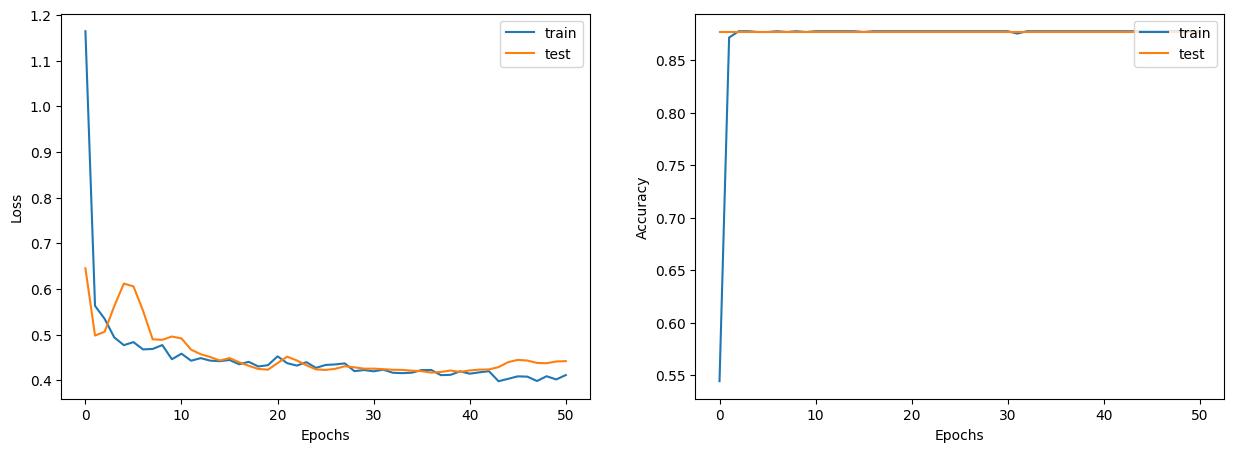

In [43]:
display_learning_curves(history)

In [44]:
x_test = test_data.Node_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 87.5%


In [47]:
from matplotlib import pyplot as plt
import math
# Testing
def test_fun(full_model,x_test,y_test):
    # X_test_new, Y_test_new = final_model(file)
    # print(X_test_new.shape, Y_test_new.shape)
    # Y_test_new = np.array(Y_test_new).astype(None)
    #k_labels = np.array(k_labels).astype(None)
    fmax, tmax = 0.0, 0.0
    precisions, recalls = [], []
    for t in range(1, 44, 1):
        test_preds = full_model.predict(x=x_test)
        #test_preds = full_model.predict(x = [seq_test_data])
        threshold = t / 100.0
        if(threshold == 1.0):
            threshold = 0.99
        print("THRESHOLD IS =====> ", threshold)
        # print(test_preds.shape)
        
        
        test_preds[test_preds>=threshold] = int(1)
        test_preds[test_preds<threshold] = int(0)
        # print(test_preds.shape)
        # print(k_labels.shape)
        rec = recall(y_test, test_preds)

        pre = precision(y_test, test_preds)
        
        recalls.append(rec)
        
        precisions.append(pre)
        # if(pre > 80):
        #   break
        f1 = f_score(y_test, test_preds)*100
        f = 2 * pre * rec / (pre + rec)
        if math.isnan(f):
          f = 0.0
        print('Recall: {0}'.format(rec*100), '     Precision: {0}'.format(pre*100),
              '     F1-score1: {0}'.format(f*100), '      F1-score2: {0}'.format(f1))

        if fmax < f:
            fmax = f
            tmax = threshold
    
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    sorted_index = np.argsort(recalls)
    recalls = recalls[sorted_index]
    precisions = precisions[sorted_index]
    aupr = np.trapz(precisions, recalls)
    print(f'AUPR: {aupr:0.3f}')

    plt.figure()
    plt.plot(recalls, precisions, color='darkorange', lw=2, label=f'AUPR curve (area = {aupr:0.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Area Under the Precision-Recall curve')
    plt.legend(loc="upper right")
    plt.savefig(f'aupr.pdf')

    return tmax
# print("*****************************************GCC EVALUATION******************************************")
# th_set_GCC = test_fun(gnn_model,x_test,y_test)
# print(th_set_GCC)

# th_set_only_LSTM = test_fun(LSTM_model,test_seq_cc,test_label_cc)


# print(th_set_only_LSTM)

In [48]:
import numpy as np
import datetime

def accuracy(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true), ', set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def precision(y_true, y_pred, normalize=True, sample_weight=None):
    pre_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_prec = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_prec = 1
            pre_list.append(tmp_prec)
        elif len(set_pred) > 0:
            tmp_prec = len(set_true.intersection(set_pred))/\
                    float(len(set_pred))
            pre_list.append(tmp_prec)
        else:
            None
    return np.mean(pre_list)

# def recall(y_true, y_pred, normalize=True, sample_weight=None):
#     rec_list = []
#     for i in range(y_true.shape[0]):
#         set_true = set( np.where(y_true[i])[0] )
#         set_pred = set( np.where(y_pred[i])[0] )
#         tmp_rec = None
#         if len(set_true) == 0 and len(set_pred) == 0:
#             tmp_rec = 1
#         else:
#             tmp_rec = len(set_true.intersection(set_pred))/\
#                     float(len(set_true))
#         rec_list.append(tmp_rec)
#     return np.mean(rec_list)

def recall(y_true, y_pred, normalize=True, sample_weight=None):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=1)
    
    rec_list = []
    
    for i in range(possible_positives.shape[0]):
        set_true = set(np.where(y_true[i])[0])
        set_pred = set(np.where(y_pred[i] >= 0.5)[0])
        
        if len(set_true) == 0:
            tmp_rec = 0
        else:
            tmp_rec = len(set_true.intersection(set_pred))/float(len(set_true))
        
        rec_list.append(tmp_rec)
    
    if normalize:
        return np.mean(rec_list)
    else:
        return np.sum(true_positives) / (np.sum(possible_positives) + K.epsilon())


def f_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = (2*len(set_true.intersection(set_pred)))/\
                    float( len(set_true) + len(set_pred))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [49]:
from keras.utils import to_categorical
# convert to one-hot encoded format
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)


*****************************************GCC EVALUATION******************************************
45/45 [==============================] - 4s 29ms/step
THRESHOLD IS =====>  0.01
Recall: 87.5      Precision: 87.5      F1-score1: 87.5       F1-score2: 87.5
45/45 [==============================] - 1s 26ms/step
THRESHOLD IS =====>  0.02
Recall: 87.5      Precision: 87.5      F1-score1: 87.5       F1-score2: 87.5
45/45 [==============================] - 1s 19ms/step
THRESHOLD IS =====>  0.03
Recall: 87.5      Precision: 87.5      F1-score1: 87.5       F1-score2: 87.5
45/45 [==============================] - 1s 21ms/step
THRESHOLD IS =====>  0.04
Recall: 87.5      Precision: 87.5      F1-score1: 87.5       F1-score2: 87.5
45/45 [==============================] - 1s 24ms/step
THRESHOLD IS =====>  0.05
Recall: 87.5      Precision: 87.5      F1-score1: 87.5       F1-score2: 87.5
45/45 [==============================] - 1s 24ms/step
THRESHOLD IS =====>  0.06
Recall: 87.5      Precision: 87.5    

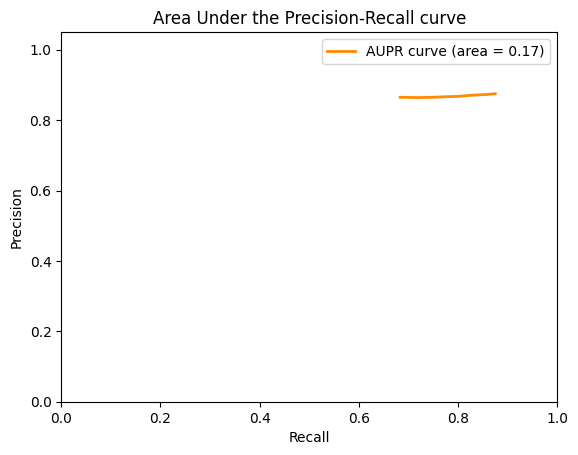

In [50]:
print("*****************************************GCC EVALUATION******************************************")
th_set_GCC = test_fun(gnn_model,x_test,y_test_onehot)
print(th_set_GCC)

0.0006600660066006601

0.030363036303630363

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# create a logistic regression model
model = LogisticRegression()

# fit the model to the training data
x_train = x_train.reshape(-1, 1)
# fit the model to the training data
x_test = x_test.reshape(-1, 1)

model.fit(x_train, y_train)

# make predictions on the training, testing, and validation data
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# evaluate the accuracy of the model on the training, testing, and validation data
Lr_test_accuracy = accuracy_score(y_test, y_test_pred)
# Lr_val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Testing accuracy: {Lr_test_accuracy}")
# print(f"Validation accuracy: {Lr_val_accuracy}")

Testing accuracy: 0.8818481848184818


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# initialize the decision tree classifier with the appropriate hyperparameters
max_depth = 10
min_samples_split = 5
model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)

# train the decision tree classifier on your training data
model.fit(x_train, y_train)


# evaluate the performance of the decision tree classifier on your testing data
y_pred_test = model.predict(x_test)
Dt_test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing accuracy: {:.2f}%".format(Dt_test_accuracy * 100))

Testing accuracy: 85.94%


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# initialize the random forest classifier with the appropriate hyperparameters
n_estimators = 100
max_depth = 10
min_samples_split = 5
model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)

# train the random forest classifier on your training data
model.fit(x_train, y_train)

# evaluate the performance of the random forest classifier on your testing data
y_pred_test = model.predict(x_test)
Rf_test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing accuracy: {:.2f}%".format(Rf_test_accuracy * 100))


Testing accuracy: 87.92%


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# initialize the SVM classifier with the appropriate hyperparameters
C = 1.0
kernel = 'rbf'
gamma = 'scale'
model = SVC(C=C, kernel=kernel, gamma=gamma)

# train the SVM classifier on your training data
model.fit(x_train, y_train)

# evaluate the performance of the SVM classifier on your testing data
y_pred_test = model.predict(x_test)
Svm_test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing accuracy: {:.2f}%".format(Svm_test_accuracy * 100))


Testing accuracy: 88.26%


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# initialize the AdaBoost classifier with the appropriate hyperparameters
n_estimators = 100
learning_rate = 1.0
algorithm = 'SAMME.R'
model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, algorithm=algorithm)

# train the AdaBoost classifier on your training data
model.fit(x_train, y_train)

# evaluate the performance of the AdaBoost classifier on your testing data
y_pred_test = model.predict(x_test)
Ada_test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing accuracy: {:.2f}%".format(Ada_test_accuracy * 100))


Testing accuracy: 88.12%


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 


# initialize the Extra Trees classifier with the appropriate hyperparameters
n_estimators = 100
max_depth = None
min_samples_split = 2
random_state = 42
model = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                             min_samples_split=min_samples_split, random_state=random_state)

# train the Extra Trees classifier on your training data
model.fit(x_train, y_train)


# evaluate the performance of the Extra Trees classifier on your testing data
y_pred_test = model.predict(x_test)
Et_test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing accuracy: {:.2f}%".format(Et_test_accuracy * 100))


Testing accuracy: 77.32%


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

# initialize the SGD classifier with the appropriate hyperparameters
alpha = 0.0001
max_iter = 1000
tol = 1e-3
model = SGDClassifier(alpha=alpha, max_iter=max_iter, tol=tol)

# train the SGD classifier on your training data
model.fit(x_train, y_train)


# evaluate the performance of the SGD classifier on your testing data
y_pred_test = model.predict(x_test)
Sgd_test_accuracy = accuracy_score(y_test, y_pred_test)
Sgd_test_recall = recall_score(y_test, y_pred_test, average = 'macro')
Sgd_test_f1_score = f1_score(y_test, y_pred_test, average = 'macro')
print("Testing accuracy: {:.2f}%".format(Sgd_test_accuracy * 100))


Testing accuracy: 88.26%


In [ ]:
Accuracies = [Dt_test_accuracy * 100, Ada_test_accuracy * 100, Lr_test_accuracy * 100, Sgd_test_accuracy * 100, Rf_test_accuracy * 100, Et_test_accuracy * 100, Svm_test_accuracy * 100]
models = ["DT","AdaBoost", "LR", "SGD",  "RF",  "ETC","SVM"]

In [ ]:
# import matplotlib.pyplot as plt
# bar_labels = ['red', 'blue', 'olive', 'orange', 'purple', 'green', 'blue']
# bar_colors = ['tab:red', 'tab:blue', 'tab:olive', 'tab:orange', 'tab:purple', 'tab:green', 'tab:blue']

# names = models
# values = Accuracies

# fig, axs = plt.subplots()
# axs.bar(names, values,label=bar_labels, color=bar_colors)
# plt.ylim(bottom=50, top=100)
# plt.rcParams["figure.figsize"] = (5,5)
# fig.suptitle('Categorical Plotting')
# fig.set_size_inches(5, 5)  # width, height in inches




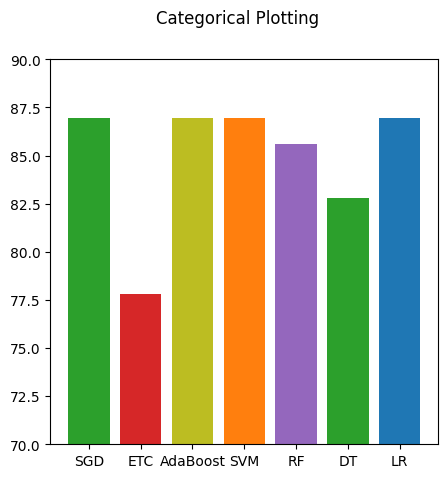

In [ ]:
import matplotlib.pyplot as plt
bar_labels = ['green', 'red', 'olive', 'orange', 'purple', 'green', 'blue']
bar_colors = ['tab:green', 'tab:red', 'tab:olive', 'tab:orange', 'tab:purple', 'tab:green', 'tab:blue']

names = ['SGD', 'ETC', 'AdaBoost', 'SVM', 'RF', 'DT','LR']
values = [86.97,  77.83, 86.97, 86.97, 85.61, 82.81, 86.97]

fig, axs = plt.subplots()
axs.bar(names, values,label=bar_labels, color=bar_colors)
plt.ylim(bottom=70, top=90)
plt.rcParams["figure.figsize"] = (5,5)
fig.suptitle('Categorical Plotting')
fig.set_size_inches(5, 5)  # width, height in inches


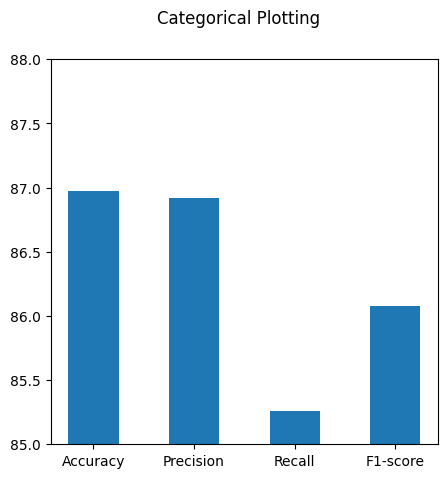

In [ ]:
import matplotlib.pyplot as plt
# bar_labels = ['red', 'blue', 'olive', 'orange', 'purple', 'green', 'blue']
# bar_colors = ['tab:red', 'tab:blue', 'tab:olive', 'tab:orange', 'tab:purple', 'tab:green', 'tab:blue']

names = ['Accuracy', 'Precision', 'Recall','F1-score']
values = [86.97, 86.92, 85.26, 86.08]

fig, axs = plt.subplots()
axs.bar(names, values,width=0.5)
plt.ylim(bottom=85, top=88)
plt.rcParams["figure.figsize"] = (4,4)
fig.suptitle('Categorical Plotting')
fig.set_size_inches(5, 5)  # width, height in inches